<a href="https://colab.research.google.com/github/sarahmfrost/compostnet/blob/bryan/compostnet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Download the Dataset

In [1]:
import os
import ipdb

#BASE_DIR = os.path.join('/content','gdrive','My Drive','dataset-compost-net-resized')
#ipdb.set_trace()
#!ls gdrive/My\ Drive/dataset-compost-net-resized

In [2]:
#DATA_DIR = BASE_DIR+"/image"

#os.chdir(DATA_DIR)
!ls

TRAINING_LOGS_FILE = "training_logs.csv"
#MODEL_SUMMARY_FILE = "/tmp/model_summary.txt"
#TEST_FILE = "/tmp/test_file.txt"

training_data_dir  = 'compostnet-dataset-resized/training/'
test_data_dir = 'compostnet-dataset-resized/test/'

TRAINING_LOGS_FILE = "training_logs.csv"
MODEL_FILE = "model.h5"

2019_Frost_CompostNet_GHTC.pdf compostnet.ipynb
Pipfile                        figures
Pipfile.lock                   scripts
README.md                      splitter.py
commands.txt                   training_logs.csv
compostnet-dataset-resized


In [3]:
# Hyperparams
 
IMAGE_WIDTH, IMAGE_HEIGHT = 400, 300
EPOCHS = 20
BATCH_SIZE = 8

# Imports

In [4]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

In [5]:
import tensorflow as tf
from tensorflow.python import keras
from keras.models import Model
from keras.layers import Input, Conv2D, MaxPooling2D, Flatten, Dense, Dropout, Activation, ZeroPadding2D
from keras.layers.merge import concatenate

from keras.optimizers import RMSprop

from keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array, array_to_img

from keras.callbacks import CSVLogger

#!pip install livelossplot
from livelossplot import PlotLossesKeras

# Load the Data

# Preprocess the Data

In [6]:
# Data augmentation
training_data_generator = ImageDataGenerator(
  rescale = 1./255,
  validation_split=0.3
)
validation_data_generator = ImageDataGenerator(rescale=1./255)
test_data_generator = ImageDataGenerator(rescale=1./255)

In [7]:
# Data Preparation
training_generator = training_data_generator.flow_from_directory(
  training_data_dir,
  target_size=(IMAGE_WIDTH, IMAGE_HEIGHT),
  batch_size = BATCH_SIZE,
  class_mode='categorical',
  subset='training')
validation_generator = training_data_generator.flow_from_directory(
  training_data_dir,
  target_size=(IMAGE_WIDTH, IMAGE_HEIGHT),
  batch_size = BATCH_SIZE,
  class_mode='categorical',
  subset='validation')
test_generator = test_data_generator.flow_from_directory(
  test_data_dir,
  target_size=(IMAGE_WIDTH, IMAGE_HEIGHT),
  color_mode="rgb",
  batch_size = 1,
  class_mode="categorical",
  shuffle=True)

Found 1417 images belonging to 2 classes.
Found 606 images belonging to 2 classes.
Found 504 images belonging to 2 classes.


# The Model

In [8]:
def build_2convolutional_layer_model(width, height, layers):
  """ Builds a x3 CNN and add details later
      https://machinelearningmastery.com/keras-functional-api-deep-learning/
  """
  
  input = Input(shape=(width, height, layers))
  
  # first feature extractor
  conv1 = Conv2D(32, kernel_size=3, activation='relu')(input)
  conv2 = Conv2D(32, kernel_size=3, activation='relu')(conv1)
  pool1 = MaxPooling2D(pool_size=(2,2))(conv2)
  
  conv3 = Conv2D(64, 3, 3, activation='relu')(pool1)
  conv4 = Conv2D(64, 3, 3, activation='relu')(conv3)
  pool2 = MaxPooling2D(pool_size=(2,2))(conv4)
  
  conv5 = Conv2D(128, 3, 3, activation='relu')(pool2)
  conv6 = Conv2D(128, 3, 3, activation='relu')(conv3)
  pool3 = MaxPooling2D(pool_size=(2,2))(conv6)
  
  conv7 = Conv2D(256, 3, 3, activation='relu')(pool3)
  conv8 = Conv2D(256, 3, 3, activation='relu')(conv3)
  pool4 = MaxPooling2D(pool_size=(2,2))(conv8)
  
  flat = Flatten()(pool4)
  hidden1 = Dense(256, activation='relu')(flat)
  drop1 = Dropout(0.5)(hidden1)
  
  hidden2= Dense(256, activation='relu')(drop1)
  drop2 = Dropout(0.5)(hidden2)
  
  
  # prediction output
  output = Dense(1, activation='sigmoid')(drop2)
  
  model = Model(inputs=input, outputs=output)
  return model

In [9]:
model = build_2convolutional_layer_model(IMAGE_WIDTH, IMAGE_HEIGHT, 3)

from keras.optimizers import Adam
model.compile(loss = 'categorical_crossentropy', optimizer=Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False),metrics=['categorical_accuracy'])

In [10]:
model.summary()

Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 400, 300, 3)]     0         
_________________________________________________________________
conv2d (Conv2D)              (None, 398, 298, 32)      896       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 396, 296, 32)      9248      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 198, 148, 32)      0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 66, 49, 64)        18496     
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 22, 16, 256)       147712    
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 11, 8, 256)       

# Training

In [ ]:
# updatable plot
# a minimal example (sort of)

class PlotLosses(tf.keras.callbacks.Callback):
    def on_train_begin(self, logs={}):
        self.i = 0
        self.x = []
        self.losses = []
        self.val_losses = []
        
        self.fig = plt.figure()
        
        self.logs = []

    def on_epoch_end(self, epoch, logs={}):
        
        self.logs.append(logs)
        self.x.append(self.i)
        self.losses.append(logs.get('loss'))
        self.val_losses.append(logs.get('val_loss'))
        self.i += 1
        
        clear_output(wait=True)
        plt.plot(self.x, self.losses, label="loss")
        plt.plot(self.x, self.val_losses, label="val_loss")
        plt.legend()
        plt.show();
        
plot_losses = PlotLosses()

In [12]:
history = model.fit_generator(
      training_generator,
      steps_per_epoch=len(training_generator.filenames) // BATCH_SIZE,
      epochs=EPOCHS,
      validation_data=validation_generator,
      validation_steps=len(validation_generator.filenames) // BATCH_SIZE,
      #callbacks=[
      #    plot_losses, keras.callbacks.CSVLogger(
      #        TRAINING_LOGS_FILE,
      #        append=False,
      #        separator=";"
      #    )
      #],
  verbose=1
)


Instructions for updating:
Please use Model.fit, which supports generators.
Epoch 1/20
177/177 [==============================] - 161s 908ms/step - loss: 1.1921e-07 - categorical_accuracy: 0.7480 - val_loss: 1.1921e-07 - val_categorical_accuracy: 0.7467
Epoch 2/20
177/177 [==============================] - 183s 1s/step - loss: 1.1921e-07 - categorical_accuracy: 0.7466 - val_loss: 1.1921e-07 - val_categorical_accuracy: 0.7500
Epoch 3/20
177/177 [==============================] - 189s 1s/step - loss: 1.1921e-07 - categorical_accuracy: 0.7480 - val_loss: 1.1921e-07 - val_categorical_accuracy: 0.7483
Epoch 4/20
177/177 [==============================] - 181s 1s/step - loss: 1.1921e-07 - categorical_accuracy: 0.7466 - val_loss: 1.1921e-07 - val_categorical_accuracy: 0.7483
Epoch 5/20
177/177 [==============================] - 172s 973ms/step - loss: 1.1921e-07 - categorical_accuracy: 0.7473 - val_loss: 1.1921e-07 - val_categorical_accuracy: 0.7467
Epoch 6/20
177/177 [=======================

In [22]:
model.save_weights(MODEL_FILE)

In [18]:
model.save('model_object')

INFO:tensorflow:Assets written to: model_object/assets


In [34]:
import pickle 

file_pi = open('model_pickle.obj', 'w')

pickle.dump(model, file_pi)

TypeError: cannot pickle '_thread.RLock' object

# Testing

In [29]:
label_map = (test_generator.class_indices)
label_map

{'class_recyclable': 0, 'class_trash': 1}

In [30]:
#open(TEST_FILE,"w")
STEP_SIZE_TEST=test_generator.n
probabilities = model.predict_generator(test_generator, steps=STEP_SIZE_TEST)

print(probabilities[:3])

Instructions for updating:
Please use Model.predict, which supports generators.
[[0.49859303]
 [0.49786365]
 [0.49816537]]


In [31]:
filenames = test_generator.filenames
nb_samples = len(filenames)
nb_samples

504

In [32]:
metrics = model.evaluate_generator(test_generator, steps=STEP_SIZE_TEST)
print(model.metrics_names)
print(metrics)

#8571428656578064

Instructions for updating:
Please use Model.evaluate, which supports generators.
['loss', 'categorical_accuracy']
[1.1920928955078125e-07, 0.7480158805847168]


In [35]:
metrics = model.evaluate(test_generator, steps=STEP_SIZE_TEST)

504/504 [==============================] - 10s 20ms/step - loss: 1.1921e-07 - categorical_accuracy: 0.7480


In [33]:
probabilities = model.predict_generator(test_generator, steps=STEP_SIZE_TEST)
print(probabilities)
print(len(probabilities))
import numpy as np
np.unique(probabilities, axis=0)
test_generator 

[[0.50104535]
 [0.49791867]
 [0.4984154 ]
 [0.49791253]
 [0.49892062]
 [0.49845442]
 [0.49846914]
 [0.49842536]
 [0.497972  ]
 [0.49865335]
 [0.49825692]
 [0.49761692]
 [0.49723065]
 [0.49957272]
 [0.49874076]
 [0.4977705 ]
 [0.49855572]
 [0.4989024 ]
 [0.49666944]
 [0.4972663 ]
 [0.49820033]
 [0.49697992]
 [0.49765047]
 [0.49727687]
 [0.4983223 ]
 [0.49873656]
 [0.49666104]
 [0.4975005 ]
 [0.49858257]
 [0.49719232]
 [0.49892384]
 [0.4974862 ]
 [0.49818754]
 [0.49863598]
 [0.49710715]
 [0.49781466]
 [0.49878928]
 [0.49892116]
 [0.49890345]
 [0.49820337]
 [0.49733448]
 [0.4978073 ]
 [0.49775892]
 [0.49830025]
 [0.4984964 ]
 [0.4983821 ]
 [0.49800453]
 [0.4970425 ]
 [0.49797943]
 [0.49785125]
 [0.49896908]
 [0.4975753 ]
 [0.49880964]
 [0.49854136]
 [0.4972833 ]
 [0.49718827]
 [0.49701616]
 [0.49807766]
 [0.49572876]
 [0.49734086]
 [0.49777892]
 [0.49709988]
 [0.4980474 ]
 [0.49807945]
 [0.4984528 ]
 [0.4966128 ]
 [0.498677  ]
 [0.49861813]
 [0.5008368 ]
 [0.4973893 ]
 [0.49747378]
 [0.49

In [36]:
test_generator.reset()
labels = ['class_recyclable', 'class_trash']

trash_total = 0

for i in range(0,504):
  x,y = test_generator.next()
  if y.argmax(axis=-1)[0] == 1:
    trash_total += 1
trash_total/504


0.251984126984127

[[0.49770808]]


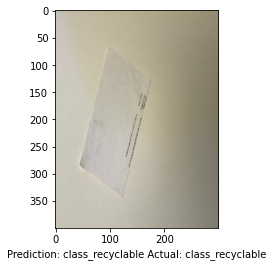

[[0.4981413]]


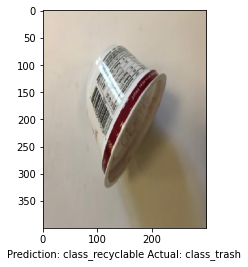

[[0.498831]]


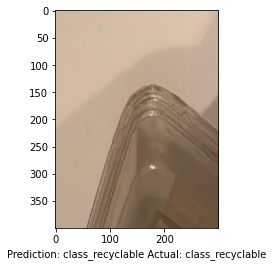

[[0.49732134]]


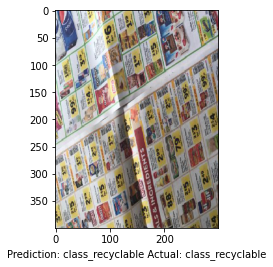

[[0.4973473]]


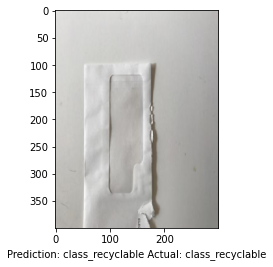

[[0.49828184]]


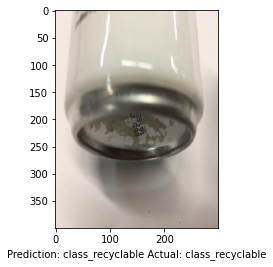

[[0.49918228]]


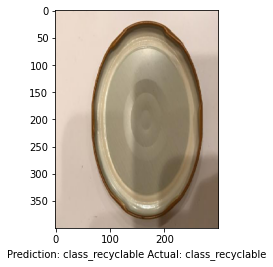

[[0.49805754]]


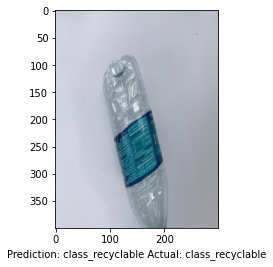

[[0.49703088]]


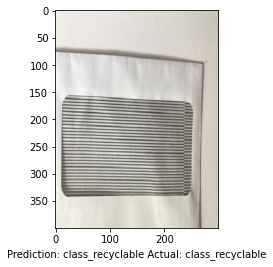

[[0.49827334]]


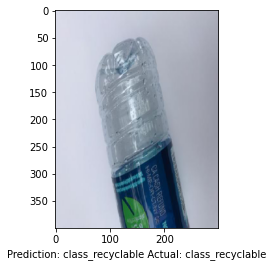

[[0.49838203]]


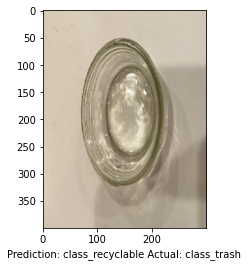

[[0.49881214]]


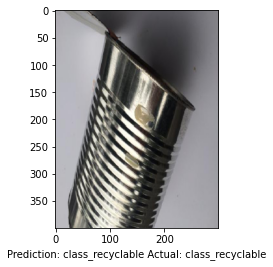

[[0.49773282]]


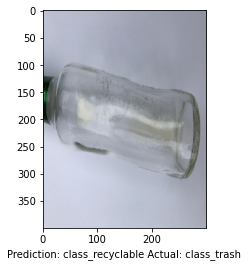

[[0.49832922]]


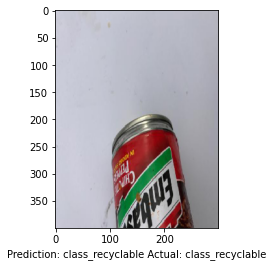

[[0.4989024]]


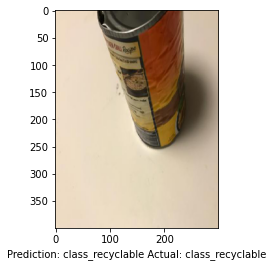

[[0.49785125]]


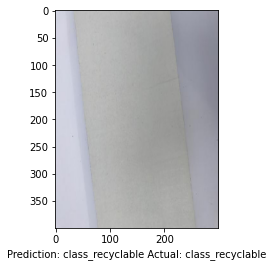

[[0.49766678]]


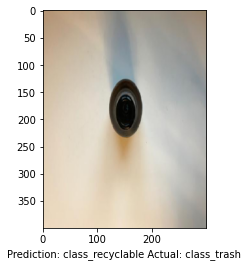

[[0.4993086]]


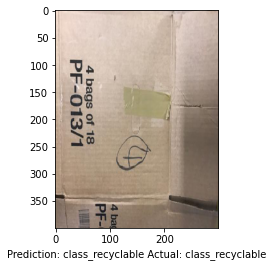

[[0.49710986]]


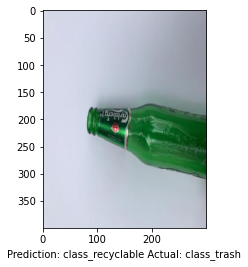

[[0.49853534]]


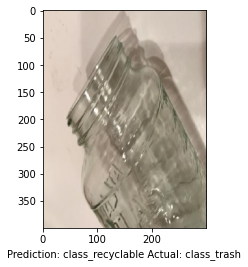

In [37]:
test_generator.reset()
labels = ['class_recyclable', 'class_trash']

for i in range(0,20):
  x,y = test_generator.next()
  image = x[0]
  plt.imshow(image)
  y_prob = model.predict(x)
  print(y_prob)
  y_classes = y_prob.argmax(axis=-1)
  plt.xlabel("Prediction: " + labels[y_classes[0]] + " Actual: " + labels[y.argmax(axis=-1)[0]])
  plt.show()